# Import section

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio
import pylops

### Cloud with data sets,models,poststack files

In [30]:
cloud = 'https://yadi.sk/d/Dw4K_GDKIMOFxQ'

### Poststack volvo file

In [2]:
segyfile = r'.\Stacks\ST0202ZDC12-PZ-PSDM-KIRCH-FULL-D.MIG_FIN.POST_STACK.3D.JS-017534.segy'

In [3]:
f = segyio.open(segyfile, ignore_geometry=True)

### Convert segy file into np.array

In [5]:
samples= f.samples
iline = f.attributes(segyio.TraceField.INLINE_3D)[:]
xline = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# all traces
traces = segyio.collect(f.trace)[:]
traces_count, traces_len = traces.shape

# seismic grid
ilines_count = np.unique(iline)
xlines_count = np.unique(xline)

# edges of grid
min_iline, max_iline = min(ilines_count), max(ilines_count)
min_xline, max_xline = min(xlines_count), max(xlines_count)

# create a grid step
grid_step = samples[1] - samples[0]
dilines = min(np.unique(np.diff(ilines_count)))
dxlines = min(np.unique(np.diff(xlines_count)))

# create a grid
ilines = np.arange(min_iline, max_iline + dilines, dilines)
xlines = np.arange(min_xline, max_xline + dxlines, dxlines)
num_ilines, num_xlines = ilines.size, xlines.size

ilines_grid, xlines_grid = np.meshgrid(np.arange(num_ilines),
                             np.arange(num_xlines),
                             indexing='ij')

# create traces indeces
traces_indeces = np.full((num_ilines, num_xlines), np.nan)
idx_il = (iline - min_iline)// dilines
idx_xl = (xline - min_xline) // dxlines
traces_indeces[idx_il, idx_xl] = np.arange(traces_count)
exist_traces = np.logical_not(np.isnan(traces_indeces))
print('# traces doesnt exist: {}'.format(np.sum(~exist_traces)))

# create a seismic cube
cube = np.zeros((num_ilines, num_xlines, traces_len))
cube[ilines_grid.ravel()[exist_traces.ravel()],
  xlines_grid.ravel()[exist_traces.ravel()]] = traces

# traces doesnt exist: 26


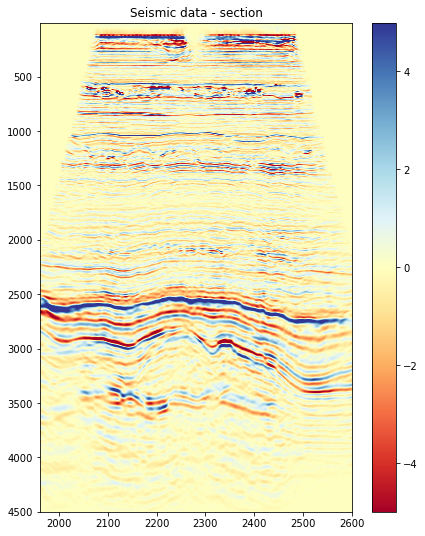

In [8]:
plt.figure(figsize=(7, 9))
plt.imshow(cube[num_ilines//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], samples[-1], samples[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight');


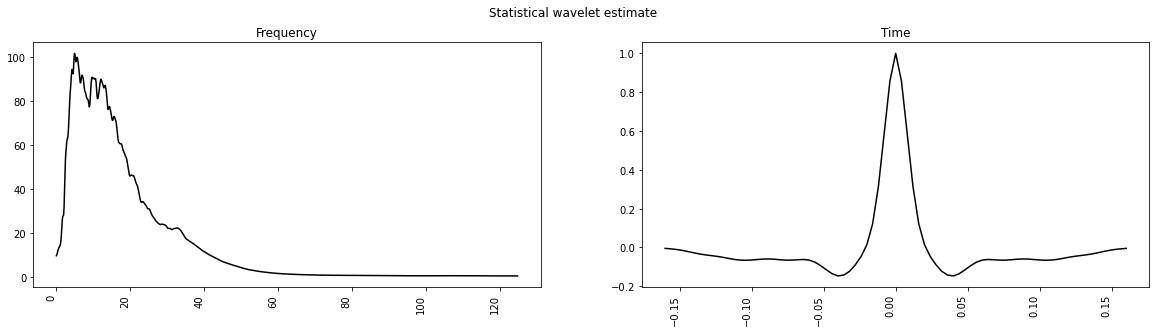

In [11]:
# lenght of wavelet in samples
wavelet_len = 41 
#  lenght of fft
fft_len = 2**11 

# time axis for wavelet
wavelet_time_axis = np.arange(wavelet_len) * (grid_step/1000) 
wavelet_time_axis = np.concatenate((np.flipud(-wavelet_time_axis[1:]), wavelet_time_axis), axis=0)

# estimate wavelet spectrum
wavelet_fft = np.mean(np.abs(np.fft.fft(cube[..., 500:], fft_len, axis=-1)), axis=(0, 1))
est_fft = np.fft.fftfreq(fft_len, d=grid_step/1000)

# create wavelet in time
wavelet_estimated = np.real(np.fft.ifft(wavelet_fft)[:wavelet_len])
wavelet_estimated = np.concatenate((np.flipud(wavelet_estimated[1:]), wavelet_estimated), axis=0)
wavelet_estimated = wavelet_estimated / wavelet_estimated.max()
center_point = np.argmax(np.abs(wavelet_estimated))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.autofmt_xdate(rotation=90)
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(est_fft[:fft_len//2], wavelet_fft[:fft_len//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(wavelet_time_axis, wavelet_estimated, 'k')
axs[1].set_title('Time');

### Visualise a wavelet

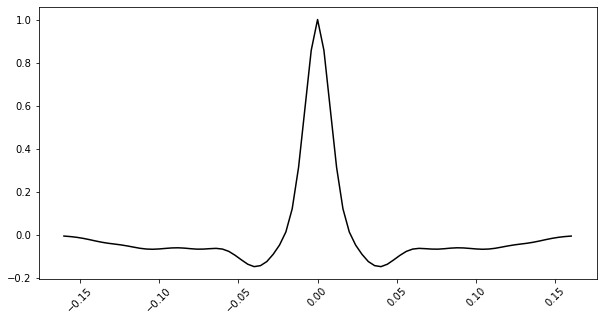

In [12]:
import matplotlib
fig,ax = plt.subplots()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)
ax.tick_params(axis='x', labelrotation=45)
ax.plot(wavelet_time_axis, wavelet_estimated, 'k')


### Inversion operation

In [13]:
# swap time axis to first dimension
time_start, time_end = 500, 950
cube_small = cube[..., time_start:time_end]
cube_small = np.swapaxes(cube_small, -1, 0)

inversed, residual= \
    pylops.avo.poststack.PoststackInversion(cube_small, wavelet_estimated, m0=np.zeros_like(cube_small), explicit=True, 
                                            epsI=1e-3, simultaneous=False)
inversed_reg, residual_reg = \
    pylops.avo.poststack.PoststackInversion(cube_small, wavelet_estimated, m0=inversed, epsI=1e-4, epsR=5e1, 
                                            **dict(iter_lim=20, show=2))
# swap time axis back to last dimension
cube_small = np.swapaxes(cube_small, 0, -1)
inversed = np.swapaxes(inversed, 0, -1)
iversed_reg = np.swapaxes(inversed_reg, 0, -1)
residual = np.swapaxes(residual, 0, -1)
residual_reg = np.swapaxes(residual_reg, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2.30976e+08 rows  and 1.15488e+08 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.820e+05  2.820e+05    1.0e+00  6.9e-04
     1 -1.31501e-02   9.380e+04  9.380e+04    3.3e-01  7.9e-01   2.1e+02  1.0e+00
     2 -1.76914e-02   8.079e+04  8.079e+04    2.9e-01  2.2e-01   3.9e+02  2.3e+00
     3 -2.43032e-02   7.547e+04  7.547e+04    2.7e-01  1.4e-01   4.7e+02  3.5e+00
     4 -3.17014e-02   7.143e+04  7.143e+04    2.5e-01  1.3e-01   5.5e+02  5.3e+00
     5 -3.91470e-02   6.723e+04  6.723e+04    2.4e-01  1.1e-01   6.2e+02  7.7e+00
     6 -4.20916e-02   6.412e+04  6.412e+04    2.3e-01  8.5e-02   6.8e+02  1.0e+01
     7 -4.03016e-02   6.151e+04  6.151e+04    2.2e-01  8.1e-02   7.3e+02  1.3e+01
     8 -3.51451e-02   

### Visualise a inversed seismic trace

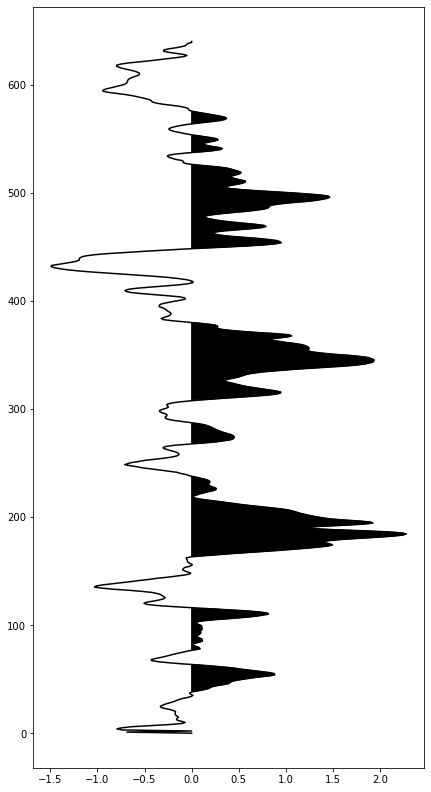

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(7, 14)
# Some example data
x = inversed[..., traces_len//3][1]
y = np.linspace(x.shape[0],0.,x.shape[0])
offset = 0.0
ax.plot(x,y,'k-')
ax.fill_betweenx(y,offset,x,where=(x>offset),color='k')
plt.show()

### Ilines section. Raw/inversed/residuals data.

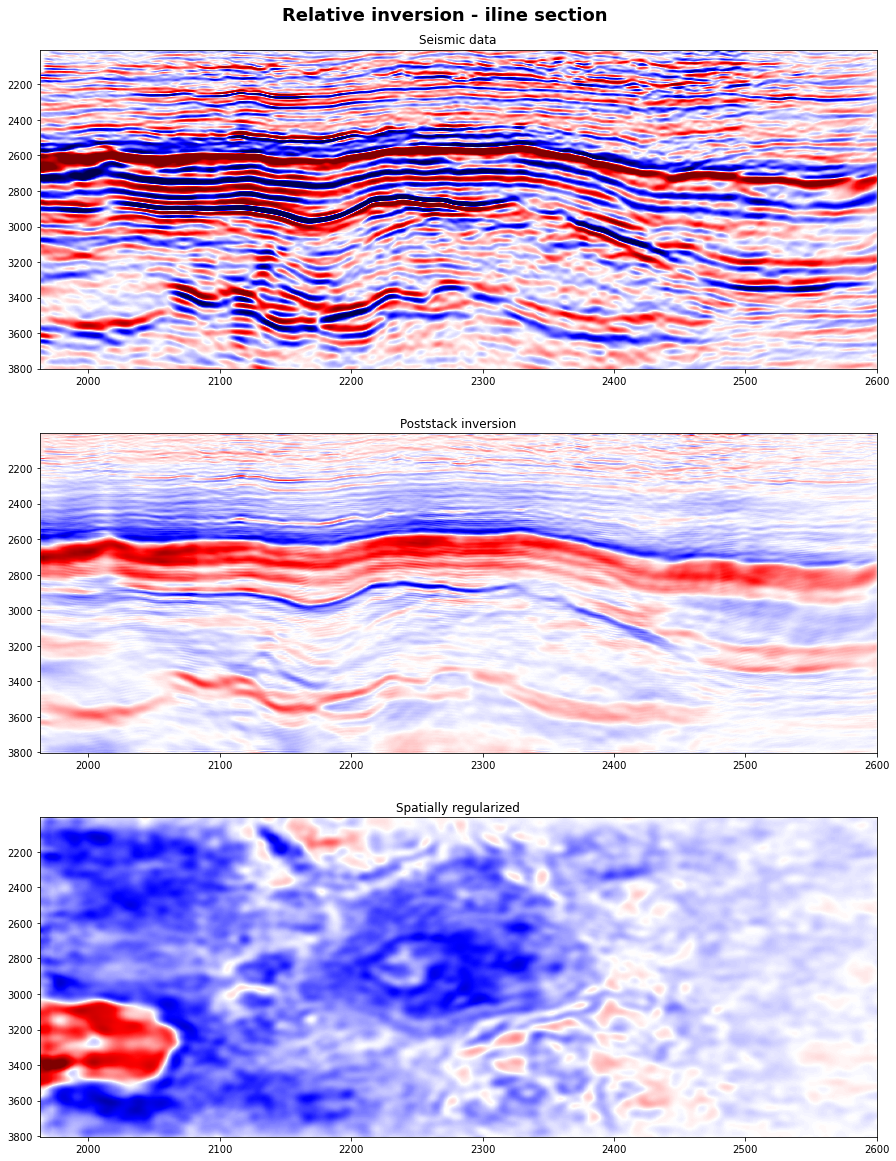

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Relative inversion - iline section', y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(cube_small[num_ilines//3].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xline[0], xline[-1], samples[time_end], samples[time_start]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(inversed[num_ilines//3].T, cmap='seismic', vmin=-0.7*inversed.max(), vmax=0.7*inversed.max(),
              extent=(xline[0], xline[-1], samples[time_end], samples[time_start]))
axs[1].set_title('Poststack inversion')
axs[1].axis('tight')
axs[2].imshow(inversed_reg[num_ilines//3].T, cmap='seismic', vmin=-0.7*inversed.max(), vmax=0.7*inversed.max(),
              extent=(xline[0], xline[-1], samples[time_end], samples[time_start]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

### Time slices section. Raw/inversed/residual data.

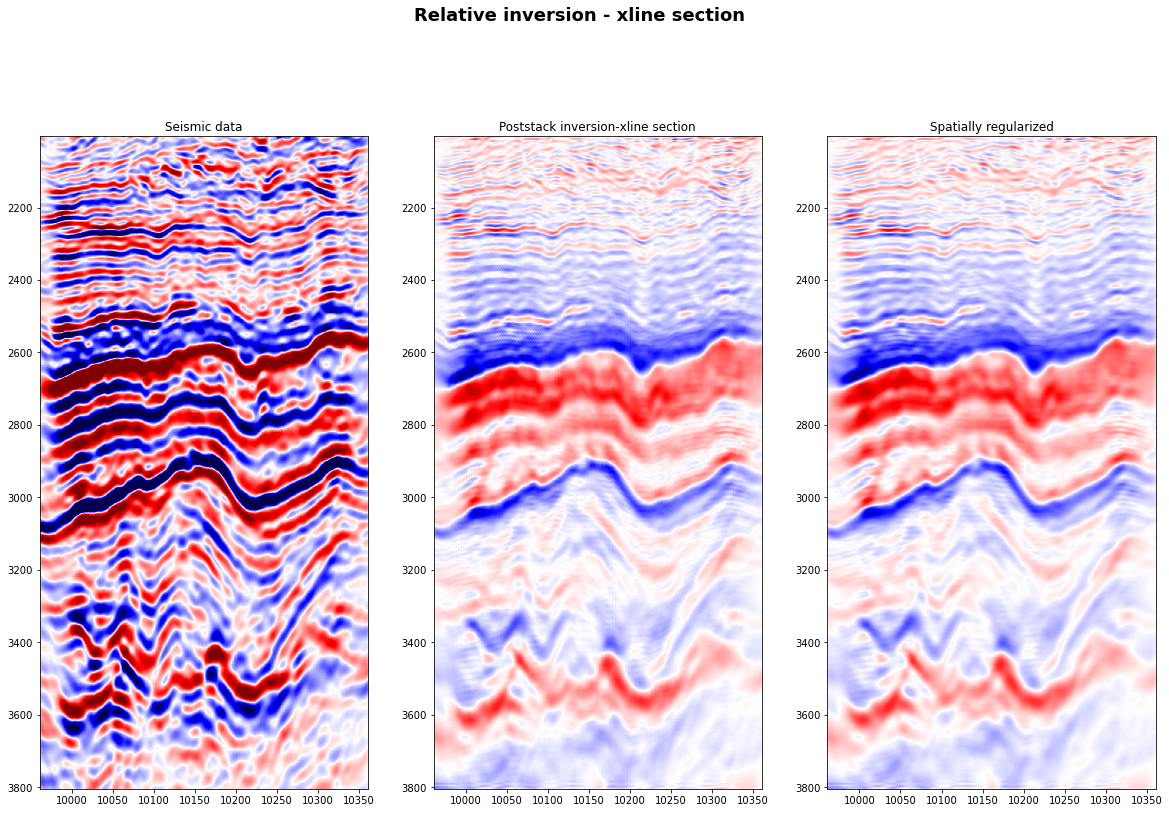

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20, 12))
fig.suptitle('Relative inversion - xline section', y=1.03, fontweight='bold', fontsize=18)
axs[0].imshow(cube_small[:, num_xlines//3].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(iline[0], iline[-1], samples[time_end], samples[time_start]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(inversed[:, num_xlines//3].T, cmap='seismic', vmin=-0.7*inversed.max(), vmax=0.7*inversed.max(),
              extent=(iline[0], iline[-1], samples[time_end], samples[time_start]))
axs[1].set_title('Poststack inversion-xline section')
axs[1].axis('tight')
axs[2].imshow(inversed_reg[:, num_xlines//3], cmap='seismic', vmin=-0.7*inversed.max(), vmax=0.7*inversed.max(),
              extent=(iline[0], iline[-1], samples[time_end], samples[time_start]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

### Save seismic time slices into png files.

In [ ]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [ ]:
for i in range(0,449,1):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.get_xaxis().set_visible(False)
    axs.get_yaxis().set_visible(False)
    axs.imshow(cube_small[...,i], cmap='seismic', vmin=-4, vmax=4,
                  extent=(xline[0], xline[-1], iline[-1], iline[0]))
    plt.savefig(r'./image_jpg/'+str(i)+'.png', dpi=300)

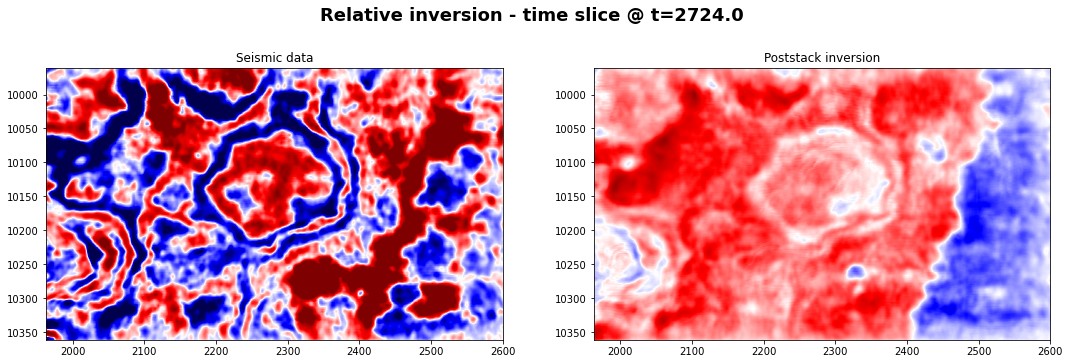

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
time_it = 180
fig.suptitle('Relative inversion - time slice @ t={}'.format(samples[time_start+180]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(cube_small[...,time_it], cmap='seismic', vmin=-4, vmax=4,
              extent=(xline[0], xline[-1], iline[-1], iline[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(inversed[...,time_it], cmap='seismic', vmin=-0.7*inversed.max(), vmax=0.7*inversed.max(),
              extent=(xline[0], xline[-1], iline[-1], iline[0]))
axs[1].set_title('Poststack inversion')
axs[1].axis('tight');

# CNN MODELS

### Create a baseline model

In [22]:
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### Training and validation directory

In [23]:
train_dir = r'.\Test\Train'
validation_dir = r'.\Test\Validation'

### Keras data generators for training and validation data sets

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True
)

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 290 images belonging to 2 classes.


### Save a model

In [26]:
model.save('seismic_baseline.h5')

### Training and validation accuracy of baseline model

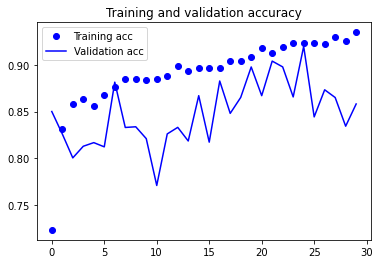

In [70]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig(r'./metrics.png', edgecolor = 'black')

### Training and validation loss of baseline model

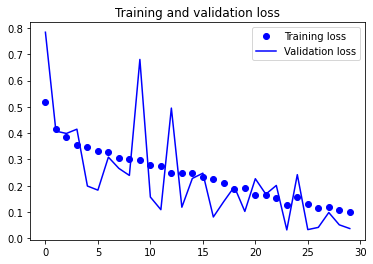

In [20]:
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(r'./loss.png',transparent=True,  edgecolor = 'black')


### Download NAS model

In [55]:
from tensorflow.keras.models import load_model
model = load_model('seismic_2.h5')

In [63]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False)

Found 43 images belonging to 1 classes.


In [64]:
test_generator.reset()

In [65]:
pred=model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

2/2 [==============================] - 2s 1s/step


In [66]:
# Get classes by np.round
cl = np.round(pred)
# Get filenames (set shuffle=false in generator is important)
filenames=test_generator.filenames

In [67]:
import pandas as pd
results=pd.DataFrame({"file":filenames,"pr":pred[:,0], "class":cl[:,0]})

In [68]:
results[results['class']==1]

,file,pr,class
36,Prediction\442.png,0.549956,1.0
37,Prediction\443.png,0.554168,1.0
41,Prediction\447.png,0.610663,1.0
42,Prediction\448.png,0.719813,1.0


In [35]:
results['class'].value_counts()

1.0    72
0.0    55
Name: class, dtype: int64